<a href="https://colab.research.google.com/github/MateusFauri/TensorFlow-/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction


In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-24 22:38:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  38.3MB/s    in 4.8s    

2023-02-24 22:38:15 (33.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = IMAGE_SHAPE,
                                               batch_size = BATCH_SIZE,
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Are extra functionality you can add to your models to be performed during or after training.
Some of the most populars:

* Tracking experiments with the TensorBoard callbacks
* Model checkpoint with the Model
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Create Model with TensorFlow Hub
We can accesses models in: 
https://tfhub.dev/

* exemple below is from: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1 

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=1):
  """
    Takes a tensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in the output layer,
        should be equal to number of target classes, default 1.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense outpu layer with num_classes output neurons.
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extractor_layer")

  model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
        ])

  return model

# Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [ ]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

resnet_history = resnet_model.fit(train_data,
                           epochs=5,
                           steps_per_epoch=len(train_data),
                           validation_data=test_data,
                           validation_steps=len(test_data),
                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230224-194544
Epoch 1/5
24/24 [==============================] - 19s 749ms/step - loss: 0.3436 - accuracy: 0.9280 - val_loss: 0.6724 - val_accuracy: 0.7788
Epoch 2/5
24/24 [==============================] - 17s 737ms/step - loss: 0.2265 - accuracy: 0.9640 - val_loss: 0.6586 - val_accuracy: 0.7804
Epoch 3/5
24/24 [==============================] - 16s 707ms/step - loss: 0.1774 - accuracy: 0.9787 - val_loss: 0.6225 - val_accuracy: 0.8000
Epoch 4/5
24/24 [==============================] - 19s 803ms/step - loss: 0.1355 - accuracy: 0.9880 - val_loss: 0.6159 - val_accuracy: 0.7956
Epoch 5/5
24/24 [==============================] - 16s 698ms/step - loss: 0.1136 - accuracy: 0.9907 - val_loss: 0.6211 - val_accuracy: 0.7968


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
    Return separate loss curves for training and validation metrics.

    Args:
      History: TensorFlow History object.

    Returns:
      Plots of training/validation loss and accuracy metrics
  """  

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

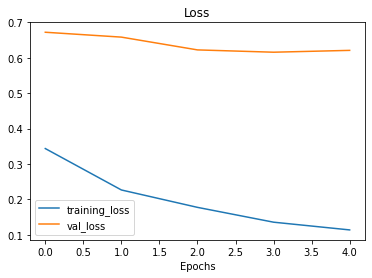

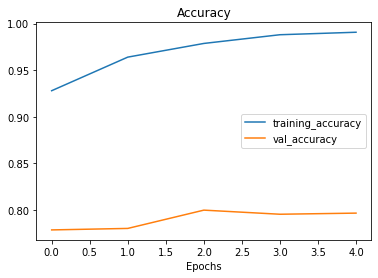

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
from keras.api._v2.keras.losses import CategoricalCrossentropy
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch = len(train_data),
                                              validation_data = test_data,
                                              validation_steps= len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                  experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230224-201041
Epoch 1/10
24/24 [==============================] - 27s 748ms/step - loss: 1.8422 - accuracy: 0.4613 - val_loss: 1.2957 - val_accuracy: 0.7304
Epoch 2/10
24/24 [==============================] - 16s 676ms/step - loss: 1.0630 - accuracy: 0.7547 - val_loss: 0.8687 - val_accuracy: 0.8248
Epoch 3/10
24/24 [==============================] - 15s 665ms/step - loss: 0.7582 - accuracy: 0.8240 - val_loss: 0.6998 - val_accuracy: 0.8416
Epoch 4/10
24/24 [==============================] - 16s 686ms/step - loss: 0.6117 - accuracy: 0.8587 - val_loss: 0.6099 - val_accuracy: 0.8512
Epoch 5/10
24/24 [==============================] - 15s 663ms/step - loss: 0.5153 - accuracy: 0.8880 - val_loss: 0.5556 - val_accuracy: 0.8604
Epoch 6/10
24/24 [==============================] - 17s 721ms/step - loss: 0.4483 - accuracy: 0.9107 - val_loss: 0.5220 - val_accuracy: 0.8632
Epoch 7/10
24/24 [==============================] - 16s 672ms/s

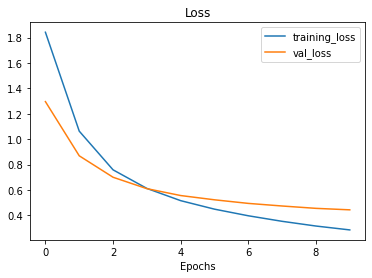

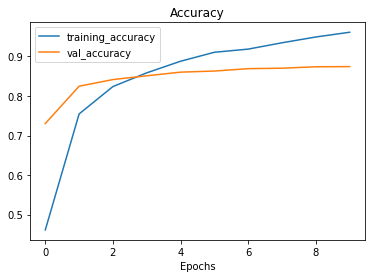

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever.
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* **"Fine-tuning"** transfer learning -  use the prelearned patterns of an existing model and "fine-tune"many or all of the underlying layers (including new output layers)

# Comparing our models results using TensorBoard


> **Note:** When upload things to TensorBoard.dev, the experiments are public!!

In [ ]:
# upload TensorBoard dev records
#!tensorboard dev upload --logdir ./tensorflow_hub/ \
#  --name "EfficientNetB0 vs. ResNet50V2" \
#  --description "Comparing two different TF hub feature extraction model architectures" \
#  --one_shot

TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/fq7sbkf9R9moF55s74qeYA/


In [ ]:
#!tensorboard dev list

2023-02-24 20:34:47.116051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-24 20:34:47.116157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-24 20:34:47.116175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/fq7sbkf9R9moF55s74qeYA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF hub fea

In [ ]:
#delete a experiment on tensorBoard
# !tensorboard dev delete --experiment_id (experiment_id_here)

# Exercices


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
#batch size will be the default - 32

train_data = "10_food_classes_10_percent/train/"
test_data = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_data,
                                               target_size = IMAGE_SHAPE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_data,
                                             target_size = IMAGE_SHAPE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [7]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feacture_extractor_layer = hub.KerasLayer(mobilenet_url,
                                          trainable=False)

mobile_model = tf.keras.Sequential([
    feacture_extractor_layer,
    tf.keras.layers.Dense(10, activation="softmax")
])

mobile_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

mobile_history = mobile_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/5
24/24 [==============================] - 29s 1s/step - loss: 2.0005 - accuracy: 0.3173 - val_loss: 1.3032 - val_accuracy: 0.6208
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0454 - accuracy: 0.7013 - val_loss: 0.8850 - val_accuracy: 0.7468
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.7420 - accuracy: 0.7960 - val_loss: 0.7422 - val_accuracy: 0.7876
Epoch 4/5
24/24 [==============================] - 16s 691ms/step - loss: 0.5939 - accuracy: 0.8440 - val_loss: 0.6833 - val_accuracy: 0.7980
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.4889 - accuracy: 0.8853 - val_loss: 0.6379 - val_accuracy: 0.8088


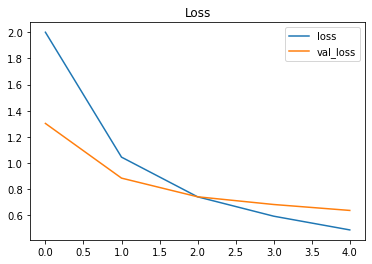

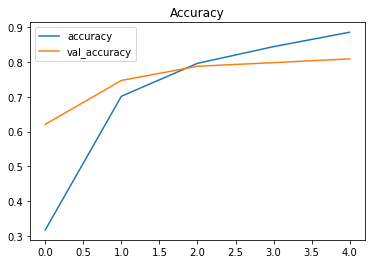

In [10]:
epochs = range(len(mobile_history.history["loss"]))

plt.plot(epochs, mobile_history.history["loss"], label="loss")
plt.plot(epochs, mobile_history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.figure()
plt.plot(epochs, mobile_history.history["accuracy"], label="accuracy")
plt.plot(epochs, mobile_history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.legend()